In [17]:
# 1. Coin Flip Example
#Import required libraries :

import random
import numpy as np

import scipy as sp

import matplotlib.pyplot as plt


In [4]:
def coin_flip():
    return random.randint(0,1)

In [30]:
# coin flip 10 times
xs = sp.stats.bernoulli.rvs(p=0.5, size=10)
sp.stats.bernoulli.pmf(xs, p=0.5)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [41]:
def coin_flip_experiment(n):
    # probability of getting heads

    events = sp.stats.bernoulli.rvs(p=0.5, size=n)
    res = 0
    prob = []
    for inx, event in enumerate(events):
        res = res + event
        prob_ = res / (inx + 1)
        prob.append(prob_)

        plt.axhline(y=0.5, color='red', linestyle='dashed')
        plt.xlabel('Number of simulations')
        plt.ylabel('Probability')
        plt.title('Monte Carlo Simulation')
        plt.plot(prob)

In [32]:
# MC simulation
prob_list = []
def monte_carlo(n):
    # n = number of simulations
    # x = number of heads
    results = 0
    for i in range(n):
        flip_result = coin_flip()
        # print("Coin result on experiment {}: {} ".format(i,flip_result))
        results = results + flip_result 
        # print("Total number of heads: {}".format(results))      

        prob_value = results/ (i+1)
        # print("Probability of heads: {}".format(prob_value))
        prob_list.append(prob_value)

        # plot the results
        plt.axhline(y=0.5, color='red', linestyle='dashed')
        plt.xlabel('Number of simulations')
        plt.ylabel('Probability')
        plt.title('Monte Carlo Simulation')
        plt.plot(prob_list)
    return prob_value/n
    

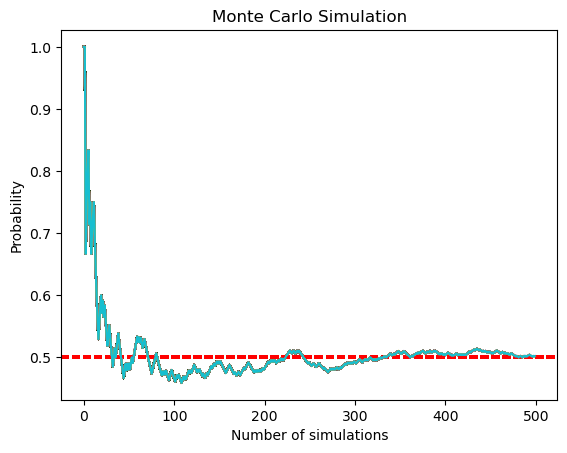

In [43]:
coin_flip_experiment(500)


In [ ]:
# Gerald -> ask about Internal data

# Intervals instead of events 

# then assumption : all valves are same and collectors same

# All collectors overlaped 